In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


(30,)


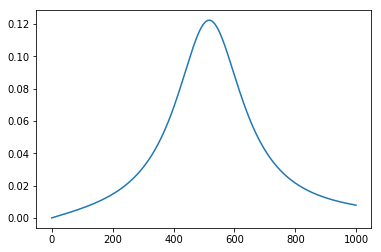

In [2]:
#setup
Nmu=30;    
Nw=1000;

mumin=0;
mumax=10;
dmu=(mumax-mumin)/Nmu

wmin=0.01;
wmax=6.;
dw=(wmax-wmin)/Nw;

Frequencies = np.array([wmin+dw*w for w in range(Nw)])

mockrho = [0.1]*Nw
for j in range(Nw):
    mockrho[j]=Frequencies[j]/((Frequencies[j]**2-3**2)**2+5**2)

#Kernel=np.array([[  (1./2. if w == 0 or w== Nw-1 else 1.) * 
#                    dw*np.exp(-(wmin+dw*w)*t)
#                  for w in range(Nw) ] for t in range(1,Nt+1)]);

Kernel=np.array([[  (1./2. if w == 0 or w== Nw-1 else 1.) * 
                    dw*2*Frequencies[w]/(Frequencies[w]**2+(mumin+dmu*mu)**2)
                  for w in range(Nw) ] for mu in range(1,Nmu+1)]);


DataIdeal = np.dot(Kernel,mockrho)

print(DataIdeal.shape)
#plt.yscale('log')
#plt.plot(DataIdeal)
plt.plot(mockrho)

In [3]:
data = [0]*Nmu

#standard deviation scaling
K=1e-3
Nmeas =1000

for i in range(Nmu):
    data[i]=(np.random.normal(loc=DataIdeal[i],scale=DataIdeal[i]*K*np.sqrt(Nmeas),size=Nmeas))
    
NoisyData=np.asarray(data)


In [4]:
def Q(b,*args):
    data=args[0]
    kernel = args[1]
    sigma = args[2]
    dw = args[3]
    alpha = args[4]
    m = args[5]
    
    rho = np.exp(b)
    
    rhodat = kernel@rho
    
    Nrho = len(rho)
    
    S=0;
    L=0;    
    
    #distance
    for i in range(len(data)):
        L+=0.5*((data[i]-rhodat[i])/sigma[i])**2
    
    #cost function
    for j in range(Nrho):
         S+=(0.5 if j == 0 or j== Nrho-1 else 1.)*(1.-rho[j]/m+np.log(rho[j]/m))*dw*alpha
         #print(S)
    #combined
    q=L-S
   
    return q

def QDer(b, *args):
    data=args[0]
    kernel = args[1]
    sigma = args[2]
    dw = args[3]
    alpha = args[4]
    m = args[5]
    
    
    rho = np.exp(b)
    
    rhodat = kernel@rho
    
    Nrho = len(rho)
    
    gradient=[0]*len(rho)
    
    
    for j in range(len(rho)):
        
        
        dwc = (0.5 if j == 0 or j== Nrho-1 else 1.)*dw
        
        tmp=0;
        
        #first finding the derivative for the "L" part
        for i in range(len(data)):
            tmp +=((data[i]-rhodat[i]))/(sigma[i]**(2))*(-kernel[i,j]*rho[j])
        
        #S derivative
        SDer =(-rho[j]/m+1.)*dwc*alpha
        
        #Combining the derivative from L and S
        gradient[j]=(tmp-SDer)
        
    return np.asarray(gradient)


In [5]:
def Reconstruct(*args):
    data=args[0] #Measured data
    kernel = args[1]
    dw = args[2]
    alpha = args[3]
    m = args[4]
    
    Nmu = len(data)
    Nmeas = len(data[1,])
    
    Nw = len(Kernel[1,])
    
    DataAverage = np.empty(Nmu)


    for j in range(len(data)):
        DataAverage[j]=np.mean(data[j,])
    
    AutoCorrelationCorr=1.; 


    DataCovarianceMatrix=AutoCorrelationCorr*np.array([[ sum( np.array([ ( data[i,n]-DataAverage[i] )*
                                     ( data[j,n]-DataAverage[j] )/((Nmeas-1.)*Nmeas) for n in range(Nmeas)]) )
                  for i in range(Nmu) ] for j in range(Nmu)]);
    
    #linalg.eig()returns two objectes diagonal e-value matrix and e-vector matrices
    DiagCorrVar,UInv=np.linalg.eig(DataCovarianceMatrix)

    #Transformed varibles
    DCDataAvg= UInv.conj().T @ DataAverage;

    DCKernel= UInv.conj().T @ Kernel;
    
    testrho = [1]*Nw
    
    result = optimize.minimize(Q, x0=testrho , args=(DCDataAvg,DCKernel,np.sqrt(DiagCorrVar),dw,alpha,m),method='L-BFGS-B',jac=QDer, options={'gtol':1e-12,'ftol':1e-12,'maxiter':10000,'disp':True, 'maxls':50})

    return np.exp(result.x)

In [6]:
def TransformData(*args):
    data=args[0] #Measured data
    kernel = args[1]
    
    Nmu = len(data)
    Nmeas = len(data[1,])
    
    Nw = len(Kernel[1,])
    
    DataAverage = np.empty(Nmu)


    for j in range(Nmu):
        DataAverage[j]=np.mean(data[j,])
    
    AutoCorrelationCorr=1.; 


    DataCovarianceMatrix=AutoCorrelationCorr*np.array([[ sum( np.array([ ( data[i,n]-DataAverage[i] )*
                                     ( data[j,n]-DataAverage[j] )/((Nmeas-1.)*Nmeas) for n in range(Nmeas)]) )
                  for i in range(Nmu) ] for j in range(Nmu)]);
    
    #linalg.eig()returns two objectes diagonal e-value matrix and e-vector matrices
    DiagCorrVar,UInv=np.linalg.eig(DataCovarianceMatrix)

    #Transformed varibles
    DCDataAvg= UInv.conj().T @ DataAverage;

    DCKernel= UInv.conj().T @ Kernel;
    
    return DCDataAvg,DCKernel,DiagCorrVar

def Reconstruct2(*args):
    DCDataAvg=args[0] 
    DCKernel = args[1]
    DiagCorrVar = args[2]
    dw = args[3]
    alpha = args[4]
    m = args[5]
    
    testrho = [1]*len(DCKernel[1,])
    
    result = optimize.minimize(Q, x0=testrho , args=(DCDataAvg,DCKernel,np.sqrt(DiagCorrVar),dw,alpha,m),method='L-BFGS-B',jac=QDer, options={'gtol':1e-12,'ftol':1e-12,'maxiter':10000,'disp':True, 'maxls':50})

    return np.exp(result.x)

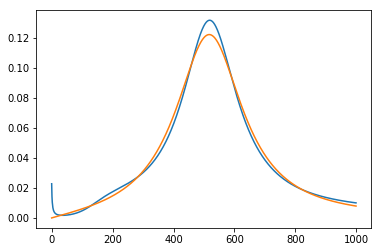

In [23]:
result = Reconstruct(NoisyData,Kernel,dw,10,3)
plt.plot(result)
plt.plot(mockrho)

In [15]:
JKernel = Kernel
JData = NoisyData
print(JKernel.shape)
print(JData.shape)
for i in range(100):
    JKernel = np.delete(JKernel,i,1)
    JData = np.delete(JData,i,1)
print(JKernel.shape)
print(JData.shape)

(30, 1000)
(30, 1000)
(30, 900)
(30, 900)


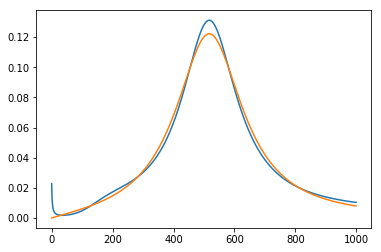

In [16]:
result = Reconstruct(JData,JKernel,dw,10,2)
plt.plot(result)
plt.plot(mockrho)

In [21]:
Nj = 10
Nr=int(Nw/Nj)
spectralfunctions = [0]*Nj

for j in range(Nj):
    JKernel = Kernel
    JData = NoisyData

    for i in range(Nr):
        JKernel = np.delete(JKernel,Nr*j,1)
        JData = np.delete(JData,Nr*j,1)
    result = Reconstruct(JData,JKernel,dw,10,0.001)
    spectralfunctions[j] = result

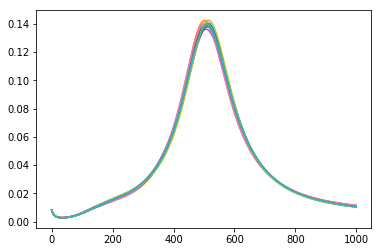

In [18]:
for j in range(Nj):
    plt.plot(spectralfunctions[j])
#plt.plot(mockrho)

In [19]:
spectralfunctions = np.asarray(spectralfunctions)

avgFun = np.array( sum(spectralfunctions,0)/Nj)

varFun = np.array( sum((spectralfunctions-avgFun)**2,0))*(Nj-1)/Nj



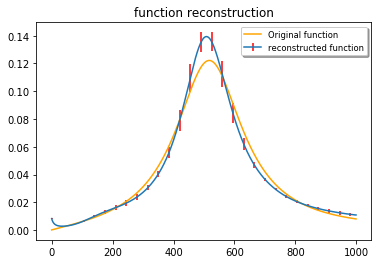

In [20]:

#fig = plt.figure()

plt.title("function reconstruction")
plt.plot(mockrho, color ='orange', label ="Original function")
#plt.plot(avgFun)
plt.errorbar(range(1000),avgFun,yerr=np.sqrt(varFun), ecolor='red', errorevery=35, label = "reconstructed function")
plt.legend(loc='upper right', shadow=True, fontsize='small')


#plt.savefig("errortest.pdf")

In [89]:
M=np.array([0.001,0.01,0.1,1,10])

Nm = len(M)
spectralfunctions2 = [0]*Nm

for m in range(Nm):
    MData, MKernel, MVar = TransformData(NoisyData,Kernel)
    spectralfunctions2[m] = Reconstruct2(MData,MKernel,MVar,dw,5,M[m])

IndexError: index 2 is out of bounds for axis 0 with size 2

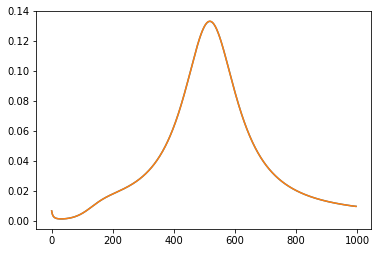

In [94]:
for j in range(Nm):
    #spectralfunctions2 = np.delete(spectralfunctions2,0,1)
    plt.plot(spectralfunctions2[j])

In [82]:
spectralfunctions2 = np.asarray(spectralfunctions2)

avgFun = np.array( sum(spectralfunctions2,0))/Nm

varFun = np.array( sum((spectralfunctions2-avgFun)**2,0))*(Nm-1)/Nm


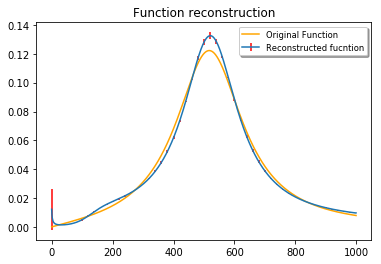

In [83]:

fig = plt.figure()

plt.title("Function reconstruction")
plt.plot(mockrho, color ='orange', label ="Original Function")
plt.errorbar(range(1000),avgFun,yerr=np.sqrt(varFun), ecolor='red', errorevery=20, label="Reconstructed fucntion")
plt.legend(loc='upper right', shadow=True, fontsize='small')

#plt.savefig("errortest.png")

<ErrorbarContainer object of 3 artists>

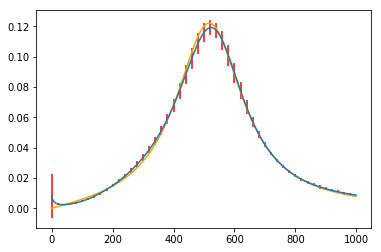

In [177]:
totalerror=[0]*len(varFun)

for j in range(len(varFun)):
    totalerror[j]=varFun[j]+varFun2[j]

#fig = plt.figure()

plt.plot(mockrho, color ='orange')
plt.errorbar(range(1000),avgFun,yerr=np.sqrt(totalerror), ecolor='red', errorevery=20)

#plt.savefig("errortest2.pdf")